# High-resolution, Multiscale, Differentiable HBV2.0 Hydrologic Model Simulation

* Developed by *Multi-scale Hydrology, Processes and Intelligence (MHPI)* team led by Dr. Chaopeng Shen at The Pennsylvania State University.

* If you find these simulation products are useful in your work, we kindly ask you cite the [publication](###Publication) below.

**Disclaimer** : In using these products you acknowledge the conditions set out in the [License](#24-terms-of-use). See online [here](https://github.com/mhpi/hydrodl2/blob/master/LICENSE).

---

<br/>

<br/>

This notebook is a tutorial for downloading and using simulation datasets generated with the high-resolution, multiscale, differentiable HBV hydrologic models dHBV2.0UH and dHBV2.0dMC.

- **dHBV2.0UH** is a high-resolution, multiscale model that uses unit hydrograph routing (UH).
- **dHBV2.0dMC** is equivalent to dHBV2.0UH with the exception of using differential Muskingum-Cunge (dMC) routing in place of UH.

<br/>

### The Datasets

The dHBV2.0 simulation product is composed of 3 datasets:

1. `1980-2020_daily_streamflow_gages`: 40 years (1980–2020) of streamflow simulations and gauge observations across 7,368 GAGES-II gauge stations, including both dHBV2.0UH and dHBV2.0dMC simulation products. This data is useful for comparison with observations.

2. `1980-2020_daily_streamflow_merit`: 40 years (1980–2020) of streamflow simulation on the seamless MERIT river network featuring the dHBV2.0dMC product.

3. `1980-2020_daily_flux_merit`: 40 years (1980–2020) of seamless spatial simulations of hydrologic variables over 180,000 MERIT unit basins on CONUS. These dHBV2.0UH simulations include baseflow, evapotranspiration (ET), soil moisture, snow water equivalent, and runoff.

See the publication below for more details.

</br>

### MERIT Hydro

These simulations utilize MERIT Hydro. While flowline geometries are included as attributes of our datasets, the full *MERIT_Hydro_v07_Basin* can also be downloaded from <https://www.reachhydro.org/home/params/merit-basins>.

Please reference the following publications for details of this global dataset:

- *Lin, P., M. Pan, H. E., Beck, Y. Yang, D. Yamazaki, R. Frasson, C. H. David, M. Durand, T. M. Pavelsky, G. H. Allen, C. J. Gleason, and E. F. Wood, 2019: Global reconstruction of naturalized river flows at 2.94 million reaches. Water Resources Research, <https://doi.org/10.1029/2019WR025287>.*

- *Yamazaki, D., Ikeshima, D., Sosa, J., Bates, P. D., Allen, G. H., & Pavelsky, T. (2019). MERIT Hydro: A high‐resolution global hydrography map based on latest topography datasets. Water Resources Research, 55, 5053–5073. <https://doi.org/10.1029/2019WR024873>*

<br/>

### Publication
*Song, Yalan, Tadd Bindas, Chaopeng Shen, Haoyu Ji, Wouter Johannes Maria Knoben, Leo Lonzarich, Martyn P. Clark et al. "High-resolution national-scale water modeling is enhanced by multiscale differentiable physics-informed machine learning." Water Resources Research (2025). <https://doi.org/10.1029/2024WR038928>*

<br/>

### Code Release

Via the differentiable modeling framework dMG:
- [dMG](https://github.com/mhpi/generic_deltamodel)
- [Zenodo](https://zenodo.org/records/14868671)
- [dhbv2](https://github.com/mhpi/dhbv2) NOAA-OWP NextGen-ready 

---

</br>

</br>

## 1. Environment Setup


In [ ]:
# Install dependencies
%pip install zarr rich xarray pandas geopandas contextily matplotlib shapely tqdm s3fs

  Using cached cligj-0.7.2-py3-none-any.whl.metadata (5.0 kB)
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------------------------------- 1.3/1.3 MB 8.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   -------------- ------------------------- 2.9/8.1 MB 16.8 MB/s eta 0:00:01
   ------------------------- -------------- 5.2/8.1 MB 14.5 MB/s eta 0:00:01
   -------------------------------------- - 7.9/8.1 MB 13.9 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 13.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 1.7/1.7 MB 13.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 2.2/2.2 MB 11.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   --------- ------------------------------ 2.6/11.0 M

In [24]:
import os
import zarr
import shutil
import s3fs
import numpy as np
import pandas as pd
import posixpath
from tqdm import tqdm
import xarray as xr
import geopandas as gpd
from pathlib import Path
from shapely import wkb
import contextily as cx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

## 2. Loading the Data (From AWS)
All three datasets can be loaded remotely from Amazon S3, which this notebook is set up to do here. Note that this can be slower than loading local data due to bandwidth limitations. To download them to your local system, see [Downloading Local Copies](#3-downloading-local-copies). If you use local copies, ensure that `IS_AWS = False`.


Be mindful of the total size of these datasets on disk (all MERIT regions combined):

* `1980-2020_daily_streamflow_gages`: ~780 MB
* `1980-2020_daily_streamflow_merit`: ~12 GB
* `1980-2020_daily_flux_merit`: ~34.5 GB

<br/>

MERIT unit basins used here are divided between 7 global hydrological zones that span CONUS: 71, 72, 73, 74, 75, 77, 78. In this code, we will use **zone 73** (US Eastern Seaboard) as an example, but this can be changed via the `MERIT_ZONE` flag below.

In [2]:
## Public AWS S3 URIs for dataset remote access
gage_qsim_path = 's3://psu-diff-water-models/dhbv2.0_40yr_dataset/1980-2020_daily_streamflow_gages'  ## 40-year (1980-2020) simulations on 7368 GAGES-II stations.
# gage_qsim_path = '/your/path/to/1980-2020_daily_streamflow_gages'

merit_qsim_path = 's3://psu-diff-water-models/dhbv2.0_40yr_dataset/1980-2020_daily_streamflow_merit'  ## 40-year (1980-2020) whole-CONUS domain simulation on seamless river network.
# merit_qsim_path = '/your/path/to/1980-2020_daily_streamflow_merit'

merit_flux_sim_path = 's3://psu-diff-water-models/dhbv2.0_40yr_dataset/1980-2020_daily_flux_merit'  ## 40-year (1980-2020) flow variables ['ET','Baseflow','Runoff','SoilMoisture','SWE'] on ~180,000 MERIT unit basins on CONUS.
# merit_flux_sim_path = '/your/path/to/1980-2020_daily_flux_merit'


MERIT_ZONE = '73'  # Select a MERIT zone.
IS_AWS = True     # Set to False if you want to use your local copies of the datasets.

### 2.1 GAGES-II Gage-level Streamflow Simulation

In [3]:
## Load gage-level streamflow data from zarr store
if IS_AWS:
    gage_qsim_root = zarr.open_group(gage_qsim_path, mode='r', storage_options={'anon': True})
else:
    gage_qsim_root = zarr.open_group(gage_qsim_path, mode='r')

gagesii_id_list = gage_qsim_root['GAGEID'][:]
gagesii_time = gage_qsim_root['Time'][:]

observations = gage_qsim_root['Observations'][:]
dhbv_uh_sim= gage_qsim_root['dHBV2.0UH_simulation'][:]     # Streamflow simulation from dHBV2.0UH
dhbv_dmc_sim = gage_qsim_root['dHBV2.0dMC_simulation'][:]  # Streamflow simulation from dHBV2.0dMC

print("Available variables in gage-level simulation: ", list(gage_qsim_root.keys()))
print("... And attributes: ", list(gage_qsim_root.attrs.keys()))

print("\ndHBV2.0dMC_simulation unit: ", gage_qsim_root['dHBV2.0dMC_simulation'].attrs['units'])
print("Gage drainage areas (km^2): ", gage_qsim_root.attrs['DrainageArea_km2'][:])

gage_qsim_root.tree()

Available variables in gage-level simulation:  ['GAGEID', 'dHBV2.0UH_simulation', 'Time', 'Observations', 'dHBV2.0dMC_simulation']
... And attributes:  ['Description', 'CRS', 'StartTime', 'EndTime', 'UseLeakance', 'UseReservoirs', 'Zone', 'SubZone', 'Forcings', 'DrainageArea_km2', 'GageLatitude', 'GageLongitude', 'Version', 'Authors', 'Contact', 'DateCreated', 'LICENSE']

dHBV2.0dMC_simulation unit:  ft3/s
Gage drainage areas (km^2):  [3186.844, 2252.696, 2313.755, 847.7721, 4278.907, 594.576, 226.2537, 450.4734, 620.6238, 242.8407, 76.73849, 1184.14, 161.9937, 264.8124, 573.6006, 385.0974, 582.0489, 444.9492, 2816.295, 8732.993, 3676.172, 304.3764, 239.0922, 769.0482, 70.1046, 844.353, 833.9643, 3011.229, 17347.38, 779.4081, 391.4991, 39.0231, 375.0849, 4124.36, 1343.69, 499.7628, 2254.018, 243.1584, 7056.902, 909.0972, 8433.685, 65.646, 1339.138, 49.3893, 1488.607, 14014.81, 561.3147, 383.8234, 2701.495, 3047.351, 3527.626, 180.981, 337.7295, 5349.329, 250.641, 439.5051, 190.9188, 85

/
├── GAGEID (7368,) <U20
├── Observations (7368, 14976) float32
├── Time (14976,) datetime64
├── dHBV2.0UH_simulation (7368, 14976) float32
└── dHBV2.0dMC_simulation (7368, 14976) float32

### 2.2 MERIT-level Streamflow Simulation

In [4]:
## Selected MERIT unit basins are divided amongst 7 zones on CONUS ['71','72','73','74','75','77','78']
## In this code, we use zone 73 as an example for loading streamflow simulations.
merit_qsim_path_i = posixpath.join(merit_qsim_path, MERIT_ZONE, '1980-01-02_2020-12-30.zarr')
if IS_AWS:
    merit_qsim_root = zarr.open(merit_qsim_path_i, mode='r', storage_options={'anon': True})
else:
    merit_qsim_root = zarr.open(merit_qsim_path_i, mode='r')

print("Available variables in MERIT-level simulation: ", list(merit_qsim_root.keys()))
print("... And attributes: ", list(merit_qsim_root.attrs.keys()))

merit_qsim_root.tree()

Available variables in MERIT-level simulation:  ['Time', 'Predictions', 'Geometry', 'COMID', 'GAGEID']
... And attributes:  ['Description', 'NOTICE', 'CRS', 'StartTime', 'EndTime', 'UseLeakance', 'UseReservoirs', 'Zone', 'SubZone', 'Version', 'Authors', 'Contact', 'DateCreated', 'Forcings', 'LICENSE']


/
├── COMID (23294,) int64
├── GAGEID (23294,) <U8
├── Geometry (23294, 11865) uint8
├── Predictions (23294, 14974) float64
└── Time (14974,) int64

### 2.3 MERIT-level Flux Simulation

In [19]:
## Select simulated fluxes from zone 73 as an example
merit_flux_sim_path_i = posixpath.join(merit_flux_sim_path, MERIT_ZONE)


## Load MERIT-level flux simulations from zarr store
if IS_AWS:
    merit_flux_sim_root = zarr.open_group(merit_flux_sim_path_i, mode='r', storage_options={'anon': True})
else:
    merit_flux_sim_root = zarr.open_group(merit_flux_sim_path_i, mode='r')

comids = merit_flux_sim_root['COMID'][:]
merit_time = merit_flux_sim_root['Time'][:]


# Flux simulations
et_sim = merit_flux_sim_root['ET'][:]  # Evapotranspiration
baseflow_sim = merit_flux_sim_root['Baseflow'][:]
Runoff_sim = merit_flux_sim_root['Runoff'][:]  # NOTE: this is runoff before routing
SoilMoisture_sim = merit_flux_sim_root['SoilMoisture'][:]
SWE_sim = merit_flux_sim_root['SWE'][:]  # Snow water equivalent

print("Available variables in MERIT-level simulation: ", list(merit_flux_sim_root.keys()))
print("... And attributes: ", list(merit_flux_sim_root.attrs.keys()))

print("\nET simulation unit: ", merit_flux_sim_root['ET'].attrs['units'])
print("SWE simulation unit: ", merit_flux_sim_root['SWE'].attrs['units'])

merit_flux_sim_root.tree()

Available variables in MERIT-level simulation:  ['Runoff', 'ET', 'Baseflow', 'SoilMoisture', 'COMID', 'SWE', 'Time', 'Geometry']
... And attributes:  ['Description', 'NOTICE', 'CRS', 'StartTime', 'EndTime', 'UseLeakance', 'UseReservoirs', 'Zone', 'SubZone', 'Forcings', 'Version', 'Authors', 'Contact', 'DateCreated', 'LICENSE']

ET simulation unit:  mm/day
SWE simulation unit:  mm


/
├── Baseflow (23294, 14976) float32
├── COMID (23294,) <U20
├── ET (23294, 14976) float32
├── Geometry (23294, 11865) uint8
├── Runoff (23294, 14976) float32
├── SWE (23294, 14976) float32
├── SoilMoisture (23294, 14976) float32
└── Time (14976,) datetime64

### 2.4 Terms of Use

In [19]:
print(gage_qsim_root.attrs['LICENSE'])

Non-Commercial Software License Agreement

    By downloading the hydroDL/hydroDL2 software and dataset (referred to as the "Software" below) you agree to
    the following terms of use:
    Copyright (c) 2020, The Pennsylvania State University (“PSU”). All rights reserved.

    1. PSU hereby grants to you a perpetual, nonexclusive and worldwide right, privilege and
    license to use, reproduce, modify, display, and create derivative works of Software for all
    non-commercial purposes only. You may not use Software for commercial purposes without
    prior written consent from PSU. Queries regarding commercial licensing should be directed
    to The Office of Technology Management at 814.865.6277 or otminfo@psu.edu.
    2. Neither the name of the copyright holder nor the names of its contributors may be used
    to endorse or promote products derived from this software without specific prior written
    permission.
    3. This software is provided for non-commercial use only.
    4.

## 3. Downloading Local Copies

The code to download local copies of each dataset are given below.

To use your own copies in this tutorial, uncomment and enter their paths [here](#2-loading-the-data-from-aws), and ensure that `IS_AWS = False`.

In [5]:
## GAGES-II streamflow simulation

GAGES_SF_SAVE_PATH = 'your/path/to/save/1980-2020_daily_streamflow_gages'


fs = s3fs.S3FileSystem(anon=True)
os.makedirs(GAGES_SF_SAVE_PATH, exist_ok=True)
fs.get(gage_qsim_path, GAGES_SF_SAVE_PATH, recursive=True);

In [ ]:
## MERIT streamflow simulation for all zones

MERIT_SF_SAVE_PATH = 'your/path/to/save/1980-2020_daily_streamflow_merit'


os.makedirs(MERIT_SF_SAVE_PATH, exist_ok=True)

for zone in tqdm(['71', '72', '73', '74', '75', '77', '78']):
    zone_path = posixpath.join(MERIT_SF_SAVE_PATH, zone, '1980-01-02_2020-12-30.zarr')
    
    fs = s3fs.S3FileSystem(anon=True)
    fs.get(gage_qsim_path, zone_path, recursive=True);

In [ ]:
## MERIT flux simulation for all zones

MERIT_FLUX_SAVE_PATH = r"C:\Users\LeoLo\Desktop\dummy" #'your/path/to/save/1980-2020_daily_flux_merit'


os.makedirs(MERIT_FLUX_SAVE_PATH, exist_ok=True)

for zone in tqdm(['71', '72', '73', '74', '75', '77', '78']):
    zone_path = posixpath.join(MERIT_FLUX_SAVE_PATH, zone)
    
    fs = s3fs.S3FileSystem(anon=True)
    fs.get(gage_qsim_path, zone_path, recursive=True);

## 4. Performance Evaluation

In [14]:
## Compute median NSE for gage-level streamflow simulations
def calc_nse(pred, target):
    ngrid,nt = pred.shape
    nse = np.full(ngrid, np.nan)

    for k in range(0, ngrid):
        x = pred[k, :]
        y = target[k, :]
        ind = np.where(np.logical_and(~np.isnan(x), ~np.isnan(y)))[0]
        if ind.shape[0] > 0:
            xx = x[ind]
            yy = y[ind]
            yymean = yy.mean()
            sst = np.sum((yy - yymean)**2)
            ssres = np.sum((yy - xx)**2)
            nse[k] = 1 - ssres/sst
    return nse


nse_dhbv_uh = calc_nse(dhbv_uh_sim,observations)
print(f"Median NSE of dHBV2.0UH streamflow simulation: {np.nanmedian(nse_dhbv_uh):.5f}")

nse_dhbv_dmc = calc_nse(dhbv_dmc_sim, observations)
print(f"\nMedian NSE of dHBV2.0dMC streamflow simulation: {np.nanmedian(nse_dhbv_dmc):.5f}")

Median NSE of dHBV2.0UH streamflow simulation: 0.65553

Median NSE of dHBV2.0dMC streamflow simulation: 0.63442


## 5. Visualization

We make a spatial plot for MERIT zone 73 below.

Note that the geometries for MERIT flowlines are stored as attributes (geojson format) of our MERIT-level simulation datasets and can be accessed via `geometry`. These flowlines are obtained directly from MERIT-Hydro and the shapefiles can also be directly accessed from <https://www.reachhydro.org/home/params/merit-basins>. 

      COMID                                           geometry
0  73000001  LINESTRING (-68.36167 45.51833, -68.36083 45.5...
1  73000002  LINESTRING (-68.22167 45.55083, -68.22083 45.5...
2  73000003  LINESTRING (-68.1775 45.56417, -68.17667 45.56...
3  73000004  LINESTRING (-68.16583 45.56417, -68.165 45.564...
4  73000005  LINESTRING (-68.125 45.56333, -68.12417 45.562...


<Axes: >

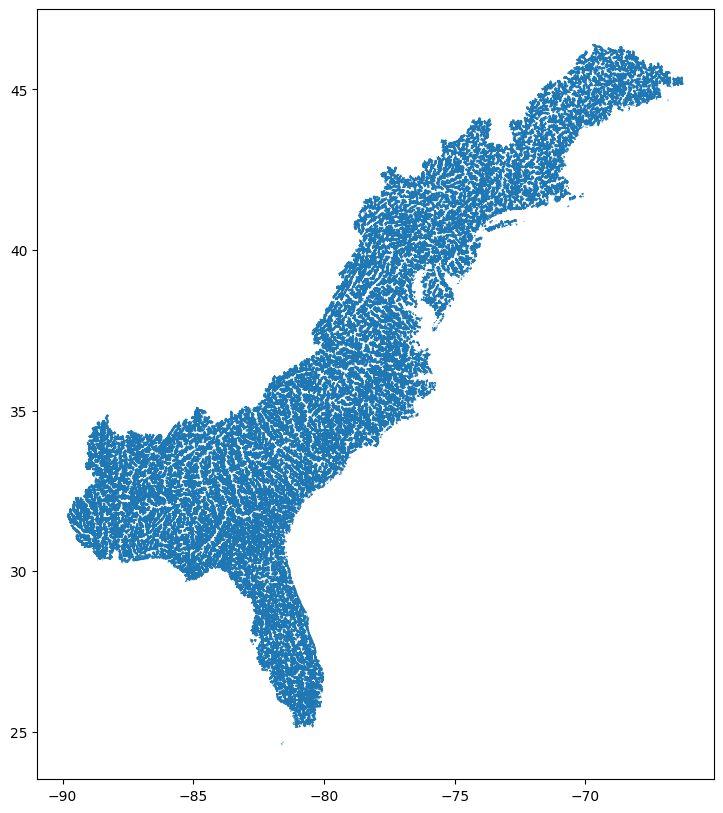

In [20]:
## Load geometries from Zarr into GDF
raw_geometry = merit_qsim_root['Geometry'][:]
geometry = [wkb.loads(bytes(row).rstrip(b'\x00')) for row in raw_geometry]

# Convert to GeoDataFrame
crs = merit_flux_sim_root.attrs['CRS']
merit_shp = gpd.GeoDataFrame(
    {'COMID': merit_qsim_root['COMID'][:].astype(int), 'geometry': geometry},
    crs=crs,
)

merit_shp.drop_duplicates(subset='COMID', keep='first', inplace=True)
merit_shp.sort_values(by='COMID', inplace=True)
merit_shp.reset_index(drop=True, inplace=True)

print(merit_shp.head())
merit_shp.plot(figsize=(10, 10))

In [23]:
## Get the mean daily values at each COMID
merit_sim_daily_mean = merit_qsim_root['Predictions'][:].mean(-1)


## Create GeoDataFrame with the mean daily streamflow and geometries for each COMID
geometry = merit_shp.geometry

d = {'mean_discharge': merit_sim_daily_mean, 'geometry': geometry}
gdf = gpd.GeoDataFrame(d)
gdf.head()

mean_discharge                                           geometry
0       78.438464  LINESTRING (-68.36167 45.51833, -68.36083 45.5...
1       61.132836  LINESTRING (-68.22167 45.55083, -68.22083 45.5...
2       60.207718  LINESTRING (-68.1775 45.56417, -68.17667 45.56...
3       57.541898  LINESTRING (-68.16583 45.56417, -68.165 45.564...
4       56.452702  LINESTRING (-68.125 45.56333, -68.12417 45.562...

Global max: 1338.3809984464694, Global min: 0.001019509852694509


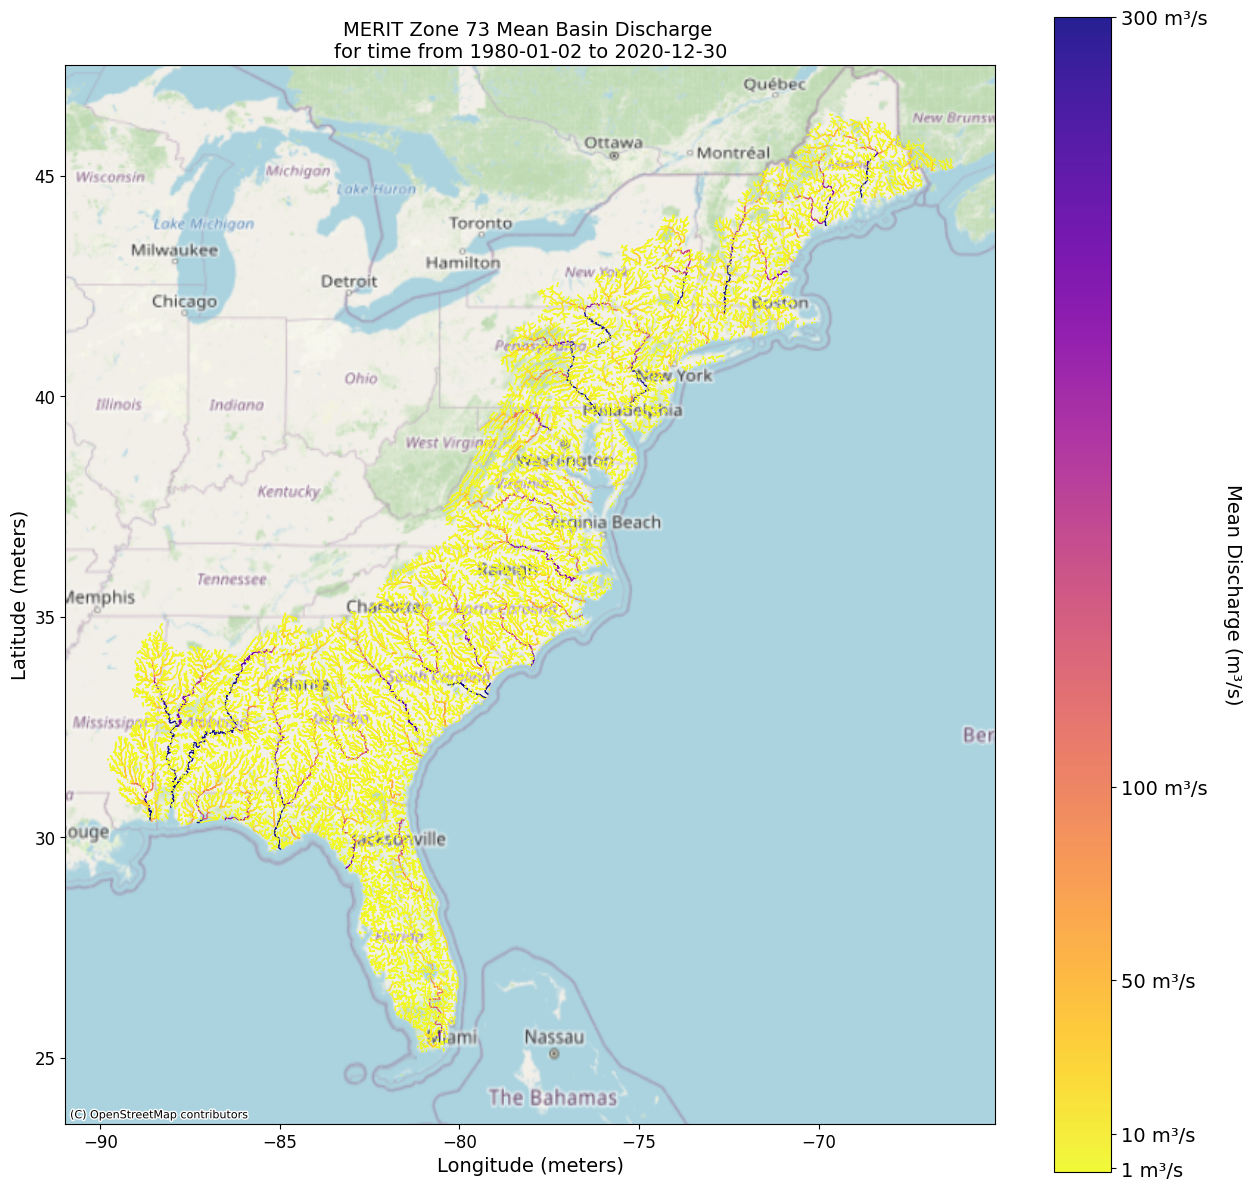

In [25]:
## Let's plot the results!
global_max = np.nanmax(merit_sim_daily_mean)
global_min = np.nanmin(merit_sim_daily_mean)

print(f"Global max: {global_max}, Global min: {global_min}")


def create_clamped_cmap(alpha, cmap, colors, trans_threshold, global_max, temp_min):
    """Create a colormap with transparency below a threshold and a fixed color above global_max."""
    # Determine transparency index for values below the threshold
    trans_idx = int((trans_threshold - temp_min) / (global_max - temp_min) * cmap.N)
    colors[:trans_idx, -1] = alpha  # Set transparency for lower values

    # Clamp colors above global_max to the darkest color
    max_idx = int((global_max - temp_min) / (global_max - temp_min) * cmap.N)  # Index for global_max
    for i in range(max_idx, cmap.N):
        colors[i] = colors[max_idx]  # Assign the max color to all values above global_max

    # Create the modified colormap
    newcmap = mcolors.LinearSegmentedColormap.from_list("CustomCmap", colors)
    return newcmap


# Parameters and setup
# --------------------- #
CBAR = None
LINEWIDTH = 0.9
THRESHOLD = 1
TEMP_MIN = 0.1
GLOBAL_MAX = 300
CMAP_NAME = 'plasma'
FIG_SIZE = (15, 15)
time_range = ['1980-01-02', '2020-12-30']
# --------------------- #


tick_values = [ 1, 10, 50, 100, GLOBAL_MAX]

# Time formatting
sim_start = merit_qsim_root.attrs['StartTime']
sim_end = merit_qsim_root.attrs['EndTime']
all_time = pd.date_range(start=sim_start, end=sim_end, freq='D')

start_idx = np.where(all_time == time_range[0])[0][0]
end_idx = np.where(all_time == time_range[1])[0][0]
discharge = gdf['mean_discharge'][start_idx:end_idx + 1]


# Prepare colormap
cmap = plt.get_cmap(CMAP_NAME).reversed()
colors = cmap(np.linspace(0, 1, cmap.N))

# Load your geospatial data (assuming it's in `gdf`)
fig, ax = plt.subplots(figsize=FIG_SIZE)

# Plot the geospatial data
gdf.plot(
    ax=ax,
    column='mean_discharge',  # Update column name as necessary
    cmap=cmap,
    linewidth=LINEWIDTH,
    vmin=TEMP_MIN,
    vmax=GLOBAL_MAX
)

# Add a map background
cx.add_basemap(
    ax,
    crs=gdf.crs,  # Ensure the CRS of your GeoDataFrame matches the basemap
    source=cx.providers.OpenStreetMap.Mapnik  # You can change this to a different map provider
)

# Add title and labels
ax.set_title(f'MERIT Zone {MERIT_ZONE} Mean Basin Discharge \nfor time from {time_range[0]} to {time_range[1]}', fontsize=14)
ax.set_xlabel('Longitude (meters)', fontsize=14)
ax.set_ylabel('Latitude (meters)', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

# Add colorbar
if CBAR:
    CBAR.remove()

sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_clim(TEMP_MIN, GLOBAL_MAX)
sm.set_array(discharge)
cbar = fig.colorbar(sm, ax=ax, alpha=0.9)
cbar.set_label('Mean Discharge (m³/s)', rotation=270, labelpad=25, fontsize=14)
cbar.set_ticks(tick_values)
cbar.set_ticklabels([ '1 m³/s', '10 m³/s', '50 m³/s','100 m³/s', f'{GLOBAL_MAX} m³/s'], fontsize=14)

plt.show()

In [26]:
## Now let's evaluate the MERIT-level simulation with GAGES-II stations in this zone
## Use GAGEID to find the availble GAGES-II stations in the selected zone
gagesII_list = merit_qsim_root['GAGEID']
gage_list = gagesII_list[np.where(np.array(gagesII_list) != '00000000')[0]]

prediction_on_edge_to_gages = merit_qsim_root['Predictions'][np.where(np.array(gagesII_list)!='00000000')[0], :]

print(f"Found {len(gage_list)} stations in MERIT zone {MERIT_ZONE}.")

Found 1614 stations in MERIT zone 73.


In [ ]:
## Load streamflow observation and evaluate the dataset on these gage stations
gage_test_list = [str(gage).zfill(8) for gage in gage_list]

## Find the index of gages in all gage station simulations we provided in 'dHBV_streamflow_simulation_gages'
subset_gage_idx = np.array([np.where(gage == gagesii_id_list)[0][0] for i, gage in enumerate(gage_test_list)])
dataset_timespan = pd.to_datetime(merit_time)

observation = gage_qsim_root['Observations'][subset_gage_idx, dataset_timespan.get_loc(time_range[0]):dataset_timespan.get_loc(time_range[1]) + 1] * 0.0283168

### NSE calculated for dataset on seamless MERIT river network in 'Yalan Song, Tadd Bindas, Chaopeng Shen, Haoyu Ji, Wouter Johannes Maria Knoben, Leo Lonzarich, Martyn P. Clark, et al. "High-resolution national-scale water modeling is enhanced by multiscale differentiable physics-informed machine learning." Water Resources Research (2025). https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1029/2024WR038928.'
### Zone forward is evaluated on edges (each MERIT unit basin can have several edges). Each edge has the length of 2 km and the most downstream edge in each MERIT is used as that respective unit basin's output.
nse_zone_forward = calc_nse(prediction_on_edge_to_gages[:, :], observation[:, :])

print("Median NSE of dataset streamflow simulation: ", np.nanmedian(nse_zone_forward))

Median NSE of dataset streamflow simulation:  0.6840424017966831
